# Learning and Decision Making

## Laboratory 6: Reinforcement learning

In the end of the lab, you should submit all code/answers written in the tasks marked as "Activity n. XXX", together with the corresponding outputs and any replies to specific questions posed to the e-mail <adi.tecnico@gmail.com>. Make sure that the subject is of the form [&lt;group n.&gt;] LAB &lt;lab n.&gt;.

### 1. The windy gridworld domain

Consider the larger version of the windy gridworld domain depicted in the figure below.

<img src="windy.png" width="400px">

In it, a boat must navigate a 7 &times; 10 gridworld, to reach the goal cell, marked with _G_. There is a crosswind upward through the middle of the grid, in the direction indicated by the gray arrows. The boat has available the standard four actions -- _Up_, _Down_, _Left_ and _Right_. In the region affected by the wind, however, the resulting next state is shifted upward as a consequence of the crosswind, the strength of which varies from column to column. The strength of the wind is given below each column, and corresponds to the number of cells that the movement is shifted upward. For example, if the boat is one cell to the right of the goal, then the action _Left_ takes you to the cell just above the goal.

The agent pays a cost of 1 in every step before reaching the goal. The problem can be described as an MDP $(\mathcal{X},\mathcal{A},\mathbf{P},c,\gamma)$ as follows.

In [1]:
%matplotlib notebook
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

np.set_printoptions(threshold=10)

# Problem specific parameters
WIND = (0, 0, 0, 1, 1, 1, 2, 2, 1, 0)
nrows = 7
ncols = 10
init = [3, 0]
goal = [3, 7]

# States
X = [[x, y] for x in range(nrows) for y in range(ncols)]
nX = len(X)

# Actions
A = ['U', 'D', 'L', 'R']
nA = len(A)

# Transition probabilities
P = dict()
P['U'] = np.zeros((nX, nX))
P['D'] = np.zeros((nX, nX))
P['L'] = np.zeros((nX, nX))
P['R'] = np.zeros((nX, nX))

for i in range(len(X)):
    x = X[i]
    y = dict()
    
    y['U'] = [x[0] - WIND[x[1]] - 1, x[1]]
    y['D'] = [x[0] - WIND[x[1]] + 1, x[1]]
    y['L'] = [x[0] - WIND[x[1]], x[1] - 1]
    y['R'] = [x[0] - WIND[x[1]], x[1] + 1]
    
    for k in y:
        y[k][0] = max(min(y[k][0], nrows - 1), 0)
        y[k][1] = max(min(y[k][1], ncols - 1), 0)
        j = X.index(y[k])
        P[k][i, j] = 1

c = np.ones((nX, nA))
c[X.index(goal), :] = 0

gamma = 0.99

# -- Pretty print

print('\n- MDP problem specification: -\n')

print('States:')
print(np.array(X))

print('\nActions:')
print(A)

print('\nTransition probabilities:')
for a in A:
    print('Action', a)
    print(P[a])
    
print('\ncost:')
print(c)
#for i, c1 in enumerate(c):
#    print(i, "->", c1)
    
print('\nStart state:', init)
print('\nGoal state:', goal)


- MDP problem specification: -

States:
[[0 0]
 [0 1]
 [0 2]
 ..., 
 [6 7]
 [6 8]
 [6 9]]

Actions:
['U', 'D', 'L', 'R']

Transition probabilities:
Action U
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Action D
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]
Action L
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]]
Action R
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]

cost:
[[ 1.  1

---

#### Activity 1.        

Compute the optimal _Q_-function for the MDP defined above using value iteration. As your stopping condition, use an error between iterations smaller than `1e-8`.

---

In [2]:
e = pow(10, -8)

err = 1
J = np.zeros((nX, 1))

cU = c[:, 0].reshape(nX, 1)
cD = c[:, 1].reshape(nX, 1)
cL = c[:, 2].reshape(nX, 1)
cR = c[:, 3].reshape(nX, 1)

qU = np.zeros((nX, 1))
qD = np.zeros((nX, 1))
qL = np.zeros((nX, 1))
qR = np.zeros((nX, 1))

while (err > 1e-8):
    qU = cU + gamma * P['U'].dot(J)
    qD = cD + gamma * P['D'].dot(J)
    qL = cL + gamma * P['L'].dot(J)
    qR = cR + gamma * P['R'].dot(J)
    newJ = np.min((qU, qD, qL, qR), axis = 0)
    err = np.linalg.norm(newJ - J)
    J = newJ
    i = i + 1

optimal_Q = np.concatenate((qU,qD,qL,qR), axis=1)

print("Q-function: \n", optimal_Q)

Q-function: 
 [[ 88.97864977  88.97864977  88.97864977  88.867323  ]
 [ 88.867323    88.867323    88.97864977  88.75487172]
 [ 88.75487172  88.75487172  88.867323    88.64128457]
 ..., 
 [ 87.18534603  87.44035764  88.29359257  87.31349257]
 [ 87.31349257  87.44035764  87.44035764  87.56595406]
 [ 87.56595406  87.56595406  87.44035764  87.56595406]]


---

#### Activity 2.        

Write down a Python function that, given a Q-function $Q$ and a state $x$, selects a random action using the $\epsilon$-greedy policy obtained from $Q$ for state $x$. Your function should receive an optional parameter, corresponding to $\epsilon$, with default value of 0.1. 

**Note:** In the case of two actions with the same value, your $\epsilon$-greedy policy should randomize between the two.

---

In [3]:
from random import uniform, randint

def greedy(q_function, x, epsilon = 0.1):
    q_line = q_function[X.index(x)]
    rand = uniform(0, 1)
    max_action_index = np.argmin(q_line)
    random_action = randint(0, len(q_line) - 1)
    action = A[max_action_index] if rand >= epsilon else A[random_action]
    return action

def greedy_value(q_function, x, epsilon = 0.1):
    q_line = q_function[X.index(x)]
    rand = uniform(0, 1)
    max_action_value = np.min(q_line)
    random_action_value = np.random.choice(q_line)
    action = max_action_value if rand >= epsilon else random_action_value
    return action

### 2. Model-based learning

You will now run the model-based learning algorithm discussed in class, and evaluate its learning performance.

---

#### Activity 3.        

Run the model-based reinforcement learning algorithm discussed in class to compute $Q^*$ for 100,000 iterations. Initialize each transition probability matrix as the identity and the cost function as all-zeros. Use an $\epsilon$-greedy policy with $\epsilon=0.1$ (use the function from Activity 2). Note that, at each step,

* You will need to select an action according to the $\epsilon$-greedy policy;
* The state and action, you will then compute the cost and generate the next state; 
* With this transition information (state, action, cost, next-state), you can now perform an update. 
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

In order to ensure that your algorithm visits every state and action a sufficient number of times, after the boat reaches the goal cell, make one further step, the corresponding update, and then reset the position of the boat to a random state in the environment.

Plot the norm $\|Q^*-Q^{(k)}\|$ every 500 iterations of your method, where $Q^*$ is the optimal _Q_~function computed in Activity 1.

**Note:** The simulation may take a bit. Don't despair.

---

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100 %


<IPython.core.display.Javascript object>


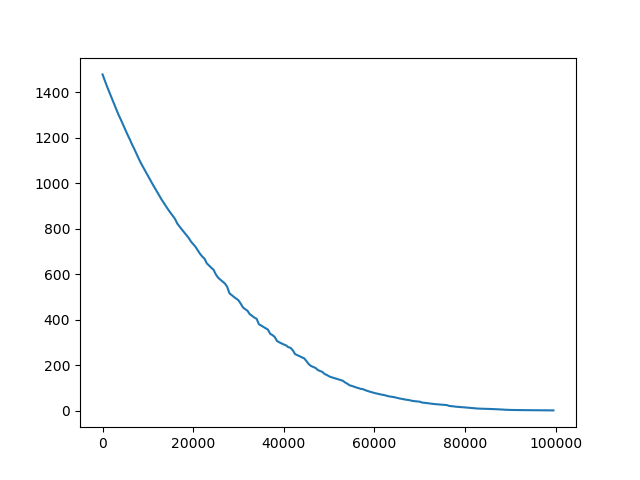

In [4]:
import matplotlib.pyplot as plt
import time

new_P = dict()
new_P['U'] = np.identity(nX)
new_P['D'] = np.identity(nX)
new_P['L'] = np.identity(nX)
new_P['R'] = np.identity(nX)

new_C = np.zeros((nX,nA))

new_Q = np.zeros((nX, nA))

N = np.zeros((nX, nA))

current_X = init
Q_difference_y = []
Q_difference_x = []

iterations = 100000

t0 = time.time()
goals1 = 0

for i in range(iterations):
    
    previous_X = None

    #select action
    current_action = greedy(new_Q, current_X)

    #apply action -> new state
    #it's deterministic, but let's do it like this
    pX = P[current_action][X.index(current_X)]
    new_X = X[np.random.choice(np.arange(nX), 1, p = pX)[0]]

    #indexes
    i_X = X.index(current_X)
    i_new_X = X.index(new_X)
    i_A = A.index(current_action)

    #new step
    step = 1 / (N[i_X, i_A] + 1)
    N[i_X, i_A] = N[i_X, i_A] + 1
    
    #update cost
    new_C[i_X, i_A] = new_C[i_X, i_A] + step*(c[i_X, i_A] - new_C[i_X, i_A])

    #update P
    p_y = np.zeros(nX)
    p_y[i_new_X] = 1
    new_P[current_action][i_X] = new_P[current_action][i_X] + step*( p_y - new_P[current_action][i_X])
    new_P[current_action][i_X] = new_P[current_action][i_X] / np.sum(new_P[current_action][i_X])

    #update Q
    new_Q[i_X, i_A] = new_C[i_X, i_A] + gamma*new_P[current_action][i_X].dot( np.min(new_Q, axis = 1) )
    
    #update state
    if (current_X == goal):
        goals1 = goals1 + 1
        current_X = X[np.random.randint(nX)]
    else:
        current_X = new_X

    #plot ya later
    if (i%500 == 0):
        Q_difference_x.append(i)
        Q_difference_y.append(np.linalg.norm(optimal_Q - new_Q))

    if (i%(iterations*.1) == 0):
        print(i*100/iterations, "%")
        
t1 = time.time() - t0
print("100 %")

plt.figure()
plt.plot(Q_difference_x, Q_difference_y)
plt.show()

### 3. Temporal-difference learning

You will now run both Q-learning and SARSA, and compare their learning performance with that of the model-based method just studied.

---

#### Activity 4.        

Repeat Activity 3 but using the _Q_-learning algorithm with a learning rate $\alpha=0.3$.

---

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100 %


<IPython.core.display.Javascript object>


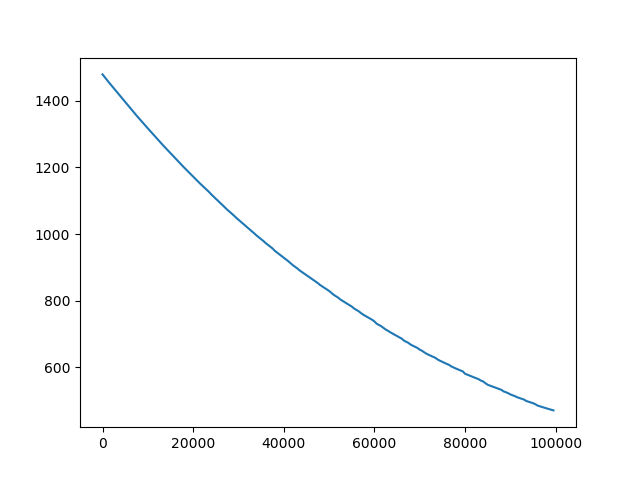

In [5]:
new_Q = np.zeros((nX, nA))

current_X = init
Q_difference_y2 = []
Q_difference_x2 = []
random_init = False

learning = 0.3

goals2 = 0

t0 = time.time()

for i in range(iterations):
    
    #select action
    current_action = greedy(new_Q, current_X)

    #apply action -> new state
    #it's deterministic, but let's do it like this
    pX = P[current_action][X.index(current_X)]
    new_X = X[np.random.choice(np.arange(nX), 1, p = pX)[0]]

    #indexes
    i_X = X.index(current_X)
    i_new_X = X.index(new_X)
    i_A = A.index(current_action)

    #Q update
    new_Q[i_X, i_A] = new_Q[i_X, i_A] + learning * (c[i_X][i_A] +  gamma * (min(new_Q[i_new_X])) - new_Q[i_X, i_A])

    #update state
    if (current_X == goal):
        goals2 = goals2 + 1
        current_X = X[np.random.randint(nX)]
    else:
        current_X = new_X
    
    #plot ya later
    if (i%500 == 0):
        Q_difference_x2.append(i)
        Q_difference_y2.append(np.linalg.norm(optimal_Q - new_Q))
        
    if (i%(iterations*.1) == 0):
        print(i*100/iterations, "%")

t2 = time.time() - t0

print("100 %")

plt.figure()
plt.plot(Q_difference_x2, Q_difference_y2)
plt.show()

---

#### Activity 5.

Repeat Activity 4 but using the SARSA algorithm.

---

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100 %


<IPython.core.display.Javascript object>


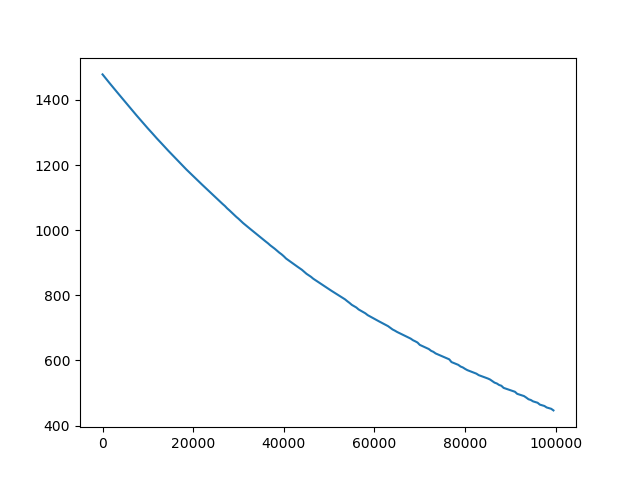

In [6]:
new_Q = np.zeros((nX, nA))

current_X = init
Q_difference_y3 = []
Q_difference_x3 = []

learning = 0.3
epsilon = 0.1

goals3 = 0

t0 = time.time()

for i in range(iterations):
    
    #select action
    current_action = greedy(new_Q, current_X)

    #apply action -> new state
    #it's deterministic, but let's do it like this
    pX = P[current_action][X.index(current_X)]
    new_X = X[np.random.choice(np.arange(nX), 1, p = pX)[0]]

    #indexes
    i_X = X.index(current_X)
    i_new_X = X.index(new_X)
    i_A = A.index(current_action)

    #Q update
    new_Q[i_X, i_A] = new_Q[i_X, i_A] + learning * (c[i_X][i_A] + gamma * greedy_value(new_Q, new_X) - new_Q[i_X, i_A])
    #new_Q[i_X, i_A] = new_Q[i_X, i_A] + learning * (c[i_X][i_A] + gamma * greedy_value(new_Q, new_X, epsilon) - new_Q[i_X, i_A])

    epsilon = epsilon - (epsilon / iterations)

    #update state
    if (current_X == goal):
        goals3 = goals3 + 1
        current_X = X[np.random.randint(nX)]
    else:
        current_X = new_X
    
    #plot ya later
    if (i%500 == 0):
        Q_difference_x3.append(i)
        Q_difference_y3.append(np.linalg.norm(optimal_Q - new_Q))
        
    if (i%(iterations*.1) == 0):
        print(i*100/iterations, "%")

t3 = time.time() - t0
print("100 %")

plt.figure()
plt.plot(Q_difference_x3, Q_difference_y3)
plt.show()

---

#### Activity 6.

Discuss the differences observed between the performance of the three methods.

---

<IPython.core.display.Javascript object>


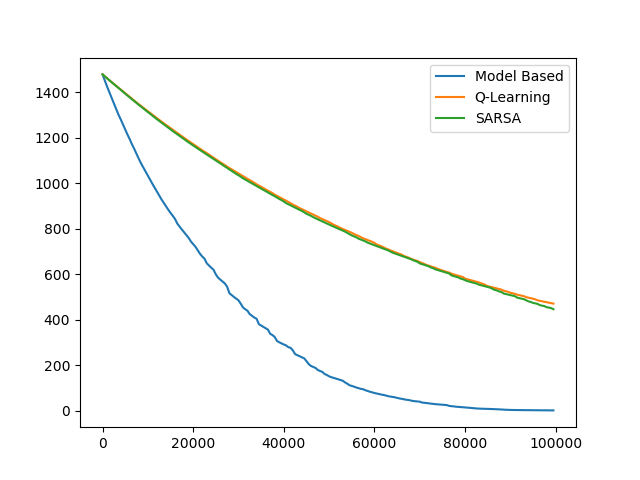

--- Model Based ---
Goals Reached:  4150
Elapsed Time:  7.9995527267456055
Last Q difference:  1.92889880794


--- Q-Learning ---
Goals Reached:  807
Elapsed Time:  4.868215322494507
Last Q difference:  471.197690563


--- SARSA ---
Goals Reached:  810
Elapsed Time:  5.979587078094482
Last Q difference:  446.570931173


In [7]:
plt.figure()
plt.plot(Q_difference_x, Q_difference_y, label='Model Based')
plt.plot(Q_difference_x2, Q_difference_y2, label='Q-Learning')
plt.plot(Q_difference_x3, Q_difference_y3, label='SARSA')
plt.legend(loc='best')
plt.show()

print("--- Model Based ---")
print("Goals Reached: ", goals1)
print("Elapsed Time: ", t1)
print("Last Q difference: ", Q_difference_y[-1])
print("\n")
print("--- Q-Learning ---")
print("Goals Reached: ", goals2)
print("Elapsed Time: ", t2)
print("Last Q difference: ", Q_difference_y2[-1])
print("\n")
print("--- SARSA ---")
print("Goals Reached: ", goals3)
print("Elapsed Time: ", t3)
print("Last Q difference: ", Q_difference_y3[-1])

As expected, the model based approach is the one that takes the longest time to finish but produces by far the best results, both in goals reached and convergence.  
The Q-Learning and SARSA algorithms produce similar results. Q-Learning is faster.  